In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [3]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation

In [4]:
# Load datasets
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    'valid',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.
Found 17573 images belonging to 38 classes.


In [5]:
# Use Pre-trained Model (Transfer Learning)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step 


In [6]:
# Freeze base model layers
base_model.trainable = False  

In [7]:
# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

In [8]:
# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,058,022 (11.67 MB)

 Trainable params: 798,502 (3.05 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)


In [10]:
# Train Model
training_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.4284 - loss: 2.1874   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1340s 608ms/step - accuracy: 0.4284 - loss: 2.1871 - val_accuracy: 0.8226 - val_loss: 0.5856 - learning_rate: 1.0000e-04
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.7703 - loss: 0.7483   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1317s 600ms/step - accuracy: 0.7703 - loss: 0.7482 - val_accuracy: 0.8539 - val_loss: 0.4560 - learning_rate: 1.0000e-04
Epoch 3/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.8211 - loss: 0.5730   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1305s 594ms/step - accuracy: 0.8211 - loss: 0.5730 - val_accuracy: 0.8708 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 4/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8387 - loss: 0.5072   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1265s 576ms/step - accuracy: 0.8387 - loss: 0.5072 - val_accuracy: 0.8844 - val_loss: 0.3502 - learning_rate: 1.0000e-04
Epoch 5/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8538 - loss: 0.4588   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1275s 580ms/step - accuracy: 0.8538 - loss: 0.4588 - val_accuracy: 0.8882 - val_loss: 0.3345 - learning_rate: 1.0000e-04
Epoch 6/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8628 - loss: 0.4291   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1255s 571ms/step - accuracy: 0.8628 - loss: 0.4291 - val_accuracy: 0.8910 - val_loss: 0.3168 - learning_rate: 1.0000e-04
Epoch 7/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8681 - loss: 0.4068   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1250s 569ms/step - accuracy: 0.8681 - loss: 0.4068 - val_accuracy: 0.8967 - val_loss: 0.3093 - learning_rate: 1.0000e-04
Epoch 8/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8769 - loss: 0.3878   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1224s 557ms/step - accuracy: 0.8769 - loss: 0.3878 - val_accuracy: 0.9001 - val_loss: 0.3025 - learning_rate: 1.0000e-04
Epoch 9/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8799 - loss: 0.3720   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1219s 555ms/step - accuracy: 0.8799 - loss: 0.3720 - val_accuracy: 0.9027 - val_loss: 0.2914 - learning_rate: 1.0000e-04
Epoch 10/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8823 - loss: 0.3622   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1344s 612ms/step - accuracy: 0.8823 - loss: 0.3622 - val_accuracy: 0.9055 - val_loss: 0.2837 - learning_rate: 1.0000e-04
Epoch 11/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1399s 637ms/step - accuracy: 0.8849 - loss: 0.3498 - val_accuracy: 0.9011 - val_loss: 0.2936 - learning_rate: 1.0000e-04
Epoch 12/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8856 - loss: 0.3460   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1403s 639ms/step - accuracy: 0.8856 - loss: 0.3460 - val_accuracy: 0.9064 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 13/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8901 - loss: 0.3347   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1410s 642ms/step - accuracy: 0.8901 - loss: 0.3347 - val_accuracy: 0.9110 - val_loss: 0.2621 - learning_rate: 1.0000e-04
Epoch 14/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8930 - loss: 0.3318   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1445s 658ms/step - accuracy: 0.8930 - loss: 0.3318 - val_accuracy: 0.9119 - val_loss: 0.2588 - learning_rate: 1.0000e-04
Epoch 15/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1556s 708ms/step - accuracy: 0.8975 - loss: 0.3195 - val_accuracy: 0.9103 - val_loss: 0.2648 - learning_rate: 1.0000e-04
Epoch 16/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1565s 712ms/step - accuracy: 0.8962 - loss: 0.3142 - val_accuracy: 0.9108 - val_loss: 0.2678 - learning_rate: 1.0000e-04
Epoch 17/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1568s 714ms/step - accuracy: 0.9004 - loss: 0.3036 - val_accuracy: 0.9114 - val_loss: 0.2634 - learning_rate: 1.0000e-04
Epoch 18/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8979 - loss: 0.3069   125

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 4182s 2s/step - accuracy: 0.8979 - loss: 0.3069 - val_accuracy: 0.9152 - val_loss: 0.2482 - learning_rate: 2.0000e-05
Epoch 19/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9040 - loss: 0.2888   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1425s 649ms/step - accuracy: 0.9040 - loss: 0.2888 - val_accuracy: 0.9155 - val_loss: 0.2462 - learning_rate: 2.0000e-05
Epoch 20/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9056 - loss: 0.2826   

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1396s 635ms/step - accuracy: 0.9056 - loss: 0.2826 - val_accuracy: 0.9173 - val_loss: 0.2406 - learning_rate: 2.0000e-05


In [11]:
model.save("final_plant_disease_model.h5")

In [12]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

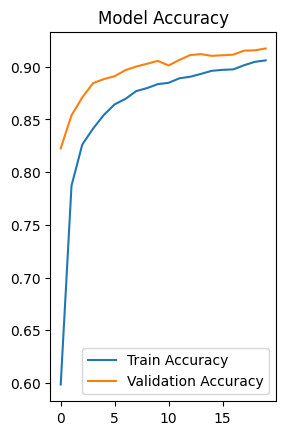

In [13]:
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Train Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')


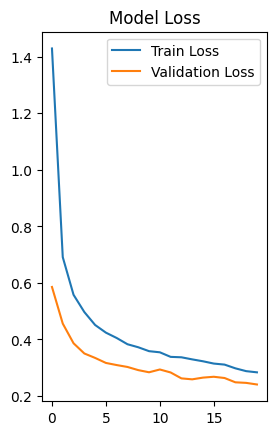

In [14]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model (update the path if necessary)
model = tf.keras.models.load_model("final_plant_disease_model.h5")

# Define the class labels as provided (order must match the training order)
class_labels = [
    'Apple__Apple_scab',
    'Apple_Black_rot',
    'Apple_Cedar_apple_rust',
    'Apple_healthy',
    'Blueberry_healthy',
    'Cherry(including_sour)Powdery_mildew',
    'Cherry(including_sour)healthy',
    'Corn(maize)Cercospora_leaf_spot Gray_leaf_spot',
    'Corn(maize)Common_rust',
    'Corn_(maize)Northern_Leaf_Blight',
    'Corn(maize)healthy',
    'Grape_Black_rot',
    'Grape_Esca(Black_Measles)',
    'Grape__Leaf_blight(Isariopsis_Leaf_Spot)',
    'Grape__healthy',
    'Orange_Haunglongbing(Citrus_greening)',
    'Peach__Bacterial_spot',
    'Peach_healthy',
    'Pepper,_bell_Bacterial_spot',
    'Pepper,_bell_healthy',
    'Potato_Early_blight',
    'Potato_Late_blight',
    'Potato_healthy',
    'Raspberry_healthy',
    'Soybean_healthy',
    'Squash_Powdery_mildew',
    'Strawberry_Leaf_scorch',
    'Strawberry_healthy',
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites Two-spotted_spider_mite',
    'Tomato_Target_Spot',
    'Tomato_Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato_Tomato_mosaic_virus',
    'Tomato__healthy'
]

# Specify the path to the test image (update with your actual image path)
img_path = 'test/image.png'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Perform prediction
predictions = model.predict(img_array)

# Get the predicted index and confidence score
predicted_index = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_index]

# Map the index to the corresponding disease name
predicted_disease = class_labels[predicted_index]

# Output the results
print(f"Predicted Disease: {predicted_disease}")
print(f"Confidence Score: {confidence_score * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Disease: Strawberry_Leaf_scorch
Confidence Score: 99.13%


In [16]:
!pip install flask